# Train agent

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm
from dm_control import suite

## Create environment

In [2]:
env = suite.load(domain_name="swimmer", task_name="swimmer6")
action_spec = env.action_spec()
t = env.reset()
state_size = sum(len(x) for x in t.observation.values())

In [3]:
print(state_size, action_spec.shape[0])

25 5


In [4]:
import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
class Memory:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []
    
    def clear_memory(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminals[:]

## Actor-Critic network

In [6]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0., std=0.1)
        nn.init.constant_(m.bias, 0.1)


class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, action_std, hidden1=64, hidden2=32):
        super(ActorCritic, self).__init__()
        self.actor =  nn.Sequential(
                nn.Linear(state_dim, hidden1),
                nn.Tanh(),
                nn.Linear(hidden1, hidden2),
                nn.Tanh(),
                nn.Linear(hidden2, action_dim),
                )

        self.critic = nn.Sequential(
                nn.Linear(state_dim, hidden1),
                nn.Tanh(),
                nn.Linear(hidden1, hidden2),
                nn.Tanh(),
                nn.Linear(hidden2, 1)
                )
        self.action_var = torch.full((action_dim,), action_std*action_std).to(device)
        self.apply(init_weights)
        
    def forward(self, x):
        pass
    
    def act(self, state, memory):
        action_mean = self.actor(state)
        cov_mat = torch.diag(self.action_var).to(device)
        
        dist = MultivariateNormal(action_mean, cov_mat)
        action = dist.sample()
        action_logprob = dist.log_prob(action)

        if memory:
            memory.states.append(state)
            memory.actions.append(action)
            memory.logprobs.append(action_logprob)

        return action.detach()
    
    def evaluate(self, state, action):   
        action_mean = self.actor(state)
        
        action_var = self.action_var.expand_as(action_mean)
        cov_mat = torch.diag_embed(action_var).to(device)
        
        dist = MultivariateNormal(action_mean, cov_mat)
        
        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        state_value = self.critic(state)
        
        return action_logprobs, torch.squeeze(state_value), dist_entropy

## Proximal Policy Optimization algorithm

In [7]:
class PPO:
    def __init__(self, state_dim, action_dim, action_std=0.5, gamma=0.99, K_epochs=80, eps_clip=0.2):
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        
        self.policy = ActorCritic(state_dim, action_dim, action_std).to(device)
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=3e-4)
        
        self.value_coef = 0.5
        self.entropy_coef = 0.001
    
    def select_action(self, state, memory):
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        with torch.no_grad():    
            action = self.policy.act(state, memory)
        action = action.cpu().numpy().flatten()
        action = np.clip(action, -1.0, 1.0)
        return action
    
    def update(self, memory):
        # Monte Carlo estimate of rewards:
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(memory.rewards), reversed(memory.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)
        
        # Form a batch
        rewards = torch.tensor(rewards).to(device)
        old_states = torch.squeeze(torch.stack(memory.states).to(device), 1).detach()
        old_actions = torch.squeeze(torch.stack(memory.actions).to(device), 1).detach()
        old_logprobs = torch.squeeze(torch.stack(memory.logprobs), 1).to(device).detach()
        
        # Optimize policy for K epochs:
        for _ in range(self.K_epochs):
            # Evaluate old actions and values :
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)
            
            # Find the ratio (pi_theta / pi_theta__old):
            ratios = torch.exp(logprobs - old_logprobs.detach())

            # Normalize the advantages
            advantages = rewards - state_values.detach()
            advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-5)

            # Surrogate loss
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages
            surr_loss = - torch.min(surr1, surr2)    # minus for maximizing surrogate loss
            
            value_loss = self.value_coef*(state_values - rewards).pow(2).mean()
            entropy_loss = self.entropy_coef*dist_entropy
            
            # Total loss 
            loss = surr_loss + value_loss - entropy_loss
            
            # Take gradient step
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()

## Wrapper for environment observations
Originally I wanted to use running mean and std to normalize observations, but it proven to be quite annoying during testing so I gave up on it.

In [8]:
class VecNormalizer(object):
    def __init__(self, obs_shape):
        self.ob_mean = np.zeros(obs_shape)
        self.m2 = np.zeros(obs_shape)
        self.epsilon = 1e-8
        self.n = 0
        
    @property
    def ob_var(self):
        if self.n <= 1:
            return 0
        else:
            return self.m2/self.n
        
    def update(self, obs):
        self.n += 1
        
        if self.n == 1:
            self.ob_mean = obs
            self.m2 = 0
        else:
            new_mean =  self.ob_mean + (obs - self.ob_mean)/self.n
            self.m2 += (obs - self.ob_mean)*(obs - new_mean);
            self.ob_mean = new_mean
        
    def __call__(self, time_step, skip_normalization=True):
        obs = np.concatenate([x for x in time_step.observation.values()])
        
        if not skip_normalization:
            self.update(obs)
            obs = (obs - self.ob_mean) / np.sqrt(self.ob_var + self.epsilon)
            obs = np.clip(obs, -10., 10.)
        
        reward = time_step.reward
        done = time_step.last()
        return obs, reward, done

## Training

In [9]:
ppo = PPO(state_size, action_spec.shape[0])
memory = Memory()
normalizer = VecNormalizer(state_size)

In [10]:
#ppo.policy.load_state_dict(torch.load("weights/PPO_swimmer_delta.pth"))

In [11]:
time_step = 0
update_timestep = 4096
max_t = 1000

max_episodes = 14000
log_interval = 20

In [23]:
scores = []
avg_dist = 0
avg_length = 0
for i_episode in range(1, max_episodes+1):
    env_step = env.reset()
    state, _, _ = normalizer(env_step)
    
    score = 0
    last_reward = None
    dist0 = np.linalg.norm(env_step.observation["to_target"])
    
    for t in range(max_t):
        time_step += 1
        
        # Select action and make a step
        action = ppo.select_action(state, memory)
        env_step = env.step(action)
        state, reward, done = normalizer(env_step)

        # Calculate reward: the difference between this and last timesteps' rewards 
        delta = 0 if last_reward is None else reward - last_reward
        last_reward = reward
        # Add encouragement for reaching target
        bonus = 0
        if reward == 1.0:   # check if reached the target
            bonus = 1000-t  # add a bonus
            done = True     # stop episode early
        
        memory.rewards.append(1000*delta + bonus)
        memory.is_terminals.append(done)

        # Update every 4096 timesteps
        if time_step % update_timestep == 0:
            ppo.update(memory)
            memory.clear_memory()

        score += reward
        if done:
            break

    # Calculate travelled ratio
    dist1 = np.linalg.norm(env_step.observation["to_target"])
    avg_dist += (dist0 - dist1)/dist0
    
    scores.append(score + (999 - t))    #add the score we would get if we didn't stop episode early
    avg_length += t
    
    # logging
    if i_episode % log_interval == 0:
        avg_dist /= log_interval
        avg_length = int(avg_length/log_interval)
        
        print("Episode {} \t Dist: {:.4f} \t Env score: {:.2f} \t Len: {}".format(i_episode, avg_dist, np.mean(scores[-20:]), avg_length))
        avg_dist = 0
        avg_length = 0
    
    if i_episode % 500 == 0:
        torch.save(ppo.policy.state_dict(), "weights/PPO_swimmer_delta_{}.pth".format(i_episode))
        
torch.save(ppo.policy.state_dict(), "weights/PPO_swimmer_delta.pth")


Episode 13860 	 Dist: 0.4896 	 Env score: 290.13 	 Len: 827
Episode 13880 	 Dist: 0.5461 	 Env score: 309.21 	 Len: 754
Episode 13900 	 Dist: 0.5616 	 Env score: 223.18 	 Len: 850
Episode 13920 	 Dist: 0.6941 	 Env score: 270.41 	 Len: 818
Episode 13940 	 Dist: 0.6261 	 Env score: 410.26 	 Len: 723
Episode 13960 	 Dist: 0.6618 	 Env score: 457.07 	 Len: 664
Episode 13980 	 Dist: 0.6152 	 Env score: 456.42 	 Len: 704
Episode 14000 	 Dist: 0.5980 	 Env score: 345.34 	 Len: 813



## Plot scores of last ~2500 episodes (smoothed)

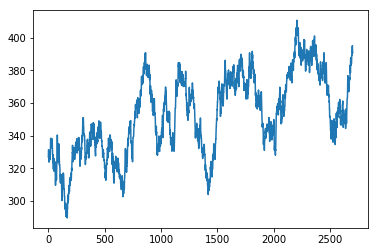

In [25]:
from scipy.ndimage.filters import uniform_filter1d
def smooth(x, N=10):
    return uniform_filter1d(x, size=N)

plt.plot(smooth(scores,200))

# Testing
## Simulate 100 episodes

In [27]:
test_episodes = 100
test_dist = []
test_scores = []

for i in tqdm.tqdm(range(test_episodes)):
    env_step = env.reset()
    state, _, _ = normalizer(env_step)
    score = 0
    
    dist0 = np.linalg.norm(env_step.observation["to_target"])

    for t in range(max_t):
        action = ppo.select_action(state, None)
        env_step = env.step(action)
        state, reward, done = normalizer(env_step)
        
        if reward == 1.0:  # reached the target
            done = True
        
        score += reward       
        if done:
            break
    test_scores.append(score + (999 - t))
    
    # How much distance travelled during episode
    dist1 = np.linalg.norm(env_step.observation["to_target"])
    dist_traveled = dist0 - dist1
    test_dist.append(dist_traveled/dist0)

100%|██████████| 100/100 [01:14<00:00,  1.36it/s]


## Visualization and analysis
### Scores

(array([51.,  8.,  4.,  7., 30.]),
 array([   6.25277043,  205.00221635,  403.75166226,  602.50110817,
         801.25055409, 1000.        ]),
 <a list of 5 Patch objects>)

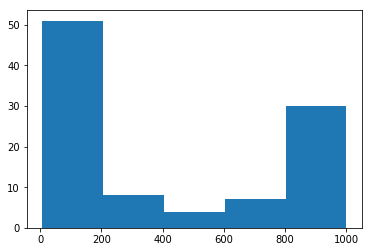

In [31]:
plt.hist(test_scores, bins=5)

In [46]:
test_scores = np.array(test_scores)
c1 = len(test_scores[test_scores<200])
m1 = np.mean(test_scores[test_scores<200])
c2 = len(test_scores[test_scores>800])
m2 = np.mean(test_scores[test_scores>800])
print("Worst cases: {} episodes ended with score <200 and mean score = {:.2f}".format(c1,m1))
print("Best cases: {} episodes ended with score >900 and mean score = {:.2f}".format(c2,m2))

Worst cases: 51 episodes ended with score <200 and mean score = 55.74
Best cases: 30 episodes ended with score >900 and mean score = 948.41


However, it is difficult to judge agent depending only on test scores, due to how rewards are calculated in this environmment. It is quite possible to spawn near the target and get a high score even though you didn't move at all.
Also, because reward does not scales linearly with the distance in my observation (it increases/decreases more if you are nead the target and less if you are far from it), if you spawn far away from the target, you will get lower score.

### Travelled distance ratio

To address this, I also tracked ratio of distence travelled, calculated like this:

`ratio = (distance_at_episode_start - distance_at_episode_end) / distance_at_episode_start`

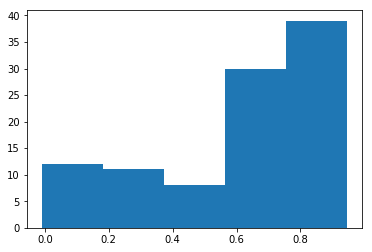

In [30]:
plt.hist(test_dist, bins=5);

In [55]:
test_dist = np.array(test_dist)
c1 = len(test_dist[test_dist>0.5])
c2 = len(test_dist[test_dist>0.9])
print("{} agents travelled more than half way, {} agents reached the target".format(c1,c2))

72 agents travelled more than half way, 17 agents reached the target


# Visualize episode

In [ ]:
def to_state(time_step):
    state = np.concatenate([x for x in time_step.observation.values()])
    return state

from dm_control import viewer
def policy(time_step):
    state = to_state(time_step)
    action = ppo.select_action(state, None)
    return action
viewer.launch(env, policy=policy)

### Video of some episodes:
https://drive.google.com/file/d/1sVEI1knVgu7chjx1tIvz54084oLbL0nh/view

### Some observations
* Snake learned a good moving pattern for moving in straight line
* However, this movement is slow and often snake doesn't have enought time to reach target
* Snake struggles at hard turns and sometimes gets locked